In [28]:
%load_ext autoreload

In [307]:
%matplotlib inline

In [29]:
from __future__ import unicode_literals

In [309]:
import sys
import os

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import matplotlib
import pandas as pd
import toolz

In [32]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# matplotlib.rc('font', family='Arial')
## for Palatino and other serif fonts use:
# rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [47]:
from toolz.curried import map
from toolz.functoolz import pipe

In [34]:
recast_path = '/Volumes/Sandisk/recast_classification/dartmouth/'
recastd_path = '/Volumes/Sandisk/recastd_classification/dartmouth/'

In [77]:
p_rnd = [1e-6, 1e-5, 1e-4, 1e-3,]

In [253]:
def build_graph(fname):  
    return nx.parse_edgelist (
        open(fname, 'r'),
        nodetype=int, 
        data=(('class', int),),
        create_using=nx.Graph()
    )

This reads the files generated by *offline* recast 

In [174]:
base = dict()
for p in p_rnd:
    base[str(p)] = build_graph(
        recast_path + os.sep + str(p) + '.txt',
    )

List every file in recastd directory. The first number is the node id and the second is the $p_{rnd}$ value used
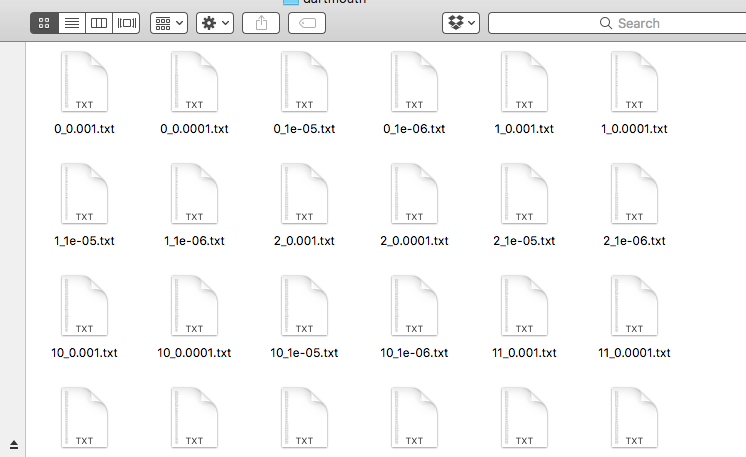

In [152]:
recastd_files = list(pipe(
    os.listdir(recastd_path),
    map(lambda x: x.strip('.txt').split('_'))
))

For each edge in $G$, check if the class assigned in the distributed recast is the same as the one assigned by the offline recast

In [273]:
acertos = dict.fromkeys(map(str, p_rnd), 0)
erros = dict.fromkeys(map(str, p_rnd), 0)

In [274]:
def compare (r, g):
    diff = 0
    equals = 0
    for e in g.edges_iter():
        assert (base[r[1]].has_edge(e[0], e[1]))
        c_r  = base[r[1]].get_edge_data(e[0], e[1])['class']
        c_rd = g.get_edge_data(e[0], e[1])['class']
        if c_r == c_rd:
            equals += 1
        else:
            diff += 1
    acertos[r[1]] += equals
    erros[r[1]] += diff

In [275]:
for r in recastd_files:
    g = build_graph(recastd_path + os.sep + r[0] + '_' + r[1] + '.txt')
    compare(r, g)

The number of hits when using $p_{rnd}$ = $0.001$ is $91632$

But the number of misses is too high ($624322$)

In [276]:
acertos

{'0.0001': 91494, '0.001': 78903, '1e-05': 104205, '1e-06': 115590}

In [277]:
erros

{'0.0001': 624186, '0.001': 636777, '1e-05': 611475, '1e-06': 600090}

In [278]:
list(map (sum, zip(acertos.values(), erros.values())))

[715680, 715680, 715680, 715680]

In [294]:
{k:[acertos[k]] for k in acertos.keys()}

{'0.0001': [91494], '0.001': [78903], '1e-05': [104205], '1e-06': [115590]}

In [293]:
[acertos['0.001']]

[78903]

In [302]:
df1 = pd.DataFrame.from_dict({k:[acertos[k]] for k in acertos.keys()})
df2 = pd.DataFrame.from_dict({k:[erros[k]] for k in erros.keys()})

In [304]:
df = pd.concat([df1, df2])

In [314]:
df = df.transpose()

In [319]:
df.columns = ['hits', 'miss']

In [336]:
df[df.columns[0]]

0.0001     91494
0.001      78903
1e-05     104205
1e-06     115590
Name: hits, dtype: int64

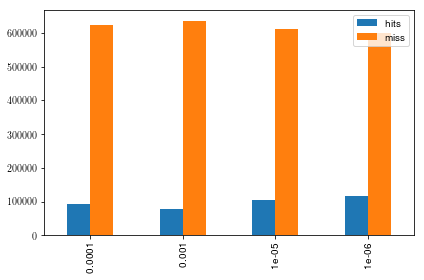

In [338]:
ax = df.plot(kind='bar', sort_columns=True)
# ax.set_xticklabels([])